In [1]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

In [2]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(4096, activation='relu')
        self.fc2 = tf.keras.layers.Dense(2048, activation='relu')
        self.fc3 = tf.keras.layers.Dense(1024, activation='relu')
        
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    
class Decoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(2048, activation='relu')
        self.fc2 = tf.keras.layers.Dense(4096, activation='relu')
        self.fc3 = tf.keras.layers.Dense(12288, activation='sigmoid')
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
encoder = Encoder()
decoder1 = Decoder()
decoder2 = Decoder()
    
inp = tf.keras.Input(shape=(64 * 64 * 3,))
enc_out = encoder(inp)
dec1_out = decoder1(enc_out)
dec2_out = decoder2(enc_out)

ae1 = tf.keras.Model(inputs=inp, outputs=dec1_out)
ae1.compile(tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy')
ae1.summary()

ae2 = tf.keras.Model(inputs=inp, outputs=dec2_out)
ae2.compile(tf.keras.optimizers.Adam(lr=1e-3), loss='binary_crossentropy')
ae2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12288)             0         
_________________________________________________________________
encoder (Encoder)            (None, 1024)              60824576  
_________________________________________________________________
decoder (Decoder)            (None, 12288)             60835840  
Total params: 121,660,416
Trainable params: 121,660,416
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12288)             0         
_________________________________________________________________
encoder (Encoder)            (None, 1024)              60824576  
______________________________________________________________

In [3]:
img_size = (64, 64)

cage_paths = list(Path('./data/faceswap/cage').glob('*.jpg'))
cage_imgs = [Image.open(path).convert('RGB').resize(img_size) for path in tqdm(cage_paths)]
cage_imgs = np.stack([np.float32(img) / 255 for img in cage_imgs], axis=0)

trump_paths = list(Path('./data/faceswap/trump').glob('*.jpg'))
trump_imgs = [Image.open(path).convert('RGB').resize(img_size) for path in tqdm(trump_paths)]
trump_imgs = np.stack([np.float32(img) / 255 for img in trump_imgs], axis=0)

def get_batch(data, batch_size):
    indices = np.random.randint(0, len(data), batch_size)
    return data[indices]

def grid(imgs, n_col=5):
    n, w, h, _ = imgs.shape
    n_row = n // n_col
    grid = np.zeros((n_row * (h + 2), n_col * (w + 2), 3), dtype=np.uint8)
    for i in range(n):
        r = (i // n_col) * (h + 2)
        c = (i % n_col) * (w + 2)
        grid[r:r+h, c:c+w] = imgs[i]
    return grid

def show(imgs, title=''):
    plt.title(title)
    plt.axis('off')
    plt.imshow(grid(np.uint8(255 * imgs)))
    plt.show()

100%|██████████| 376/376 [00:00<00:00, 661.42it/s]


In [4]:
history = []

for step in tqdm(range(500)):
    cage_img_b = get_batch(cage_imgs, 64).reshape(64, -1)
    trump_img_b = get_batch(trump_imgs, 64).reshape(64, -1)
    
    loss1 = ae1.train_on_batch(cage_img_b, cage_img_b)
    loss2 = ae2.train_on_batch(trump_img_b, trump_img_b)
    
    if step % 10 == 0:
        history.append({
            'step': step,
            'loss1': loss1,
            'loss2': loss2
        })

100%|██████████| 500/500 [01:10<00:00,  8.04it/s]


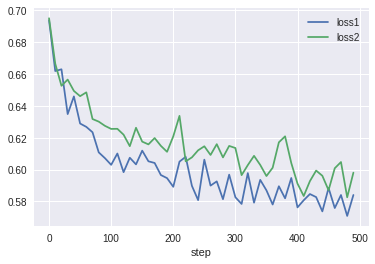

In [5]:
df = pd.DataFrame(history)
fig, ax = plt.subplots()
df.plot(kind='line', x='step', y='loss1', ax=ax)
df.plot(kind='line', x='step', y='loss2', ax=ax)
plt.show()

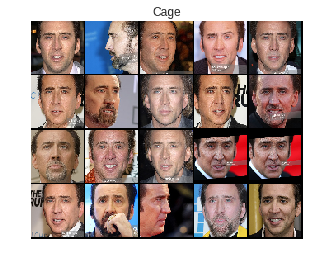

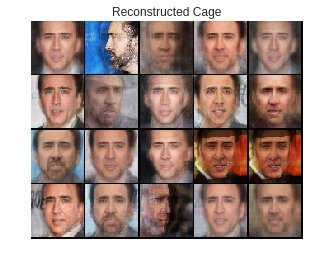

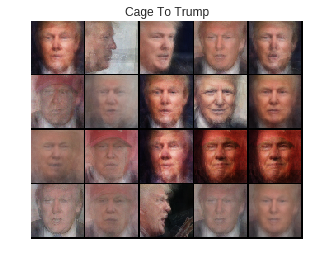

In [6]:
cage_test = get_batch(cage_imgs, 20)
cage_back = ae1.predict(cage_test.reshape(20, -1)).reshape(-1, 64, 64, 3)
cage_trump = ae2.predict(cage_test.reshape(20, -1)).reshape(-1, 64, 64, 3)

show(cage_test, 'Cage')
show(cage_back, 'Reconstructed Cage')
show(cage_trump, 'Cage To Trump')

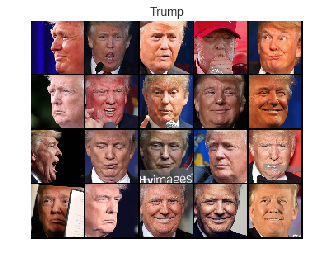

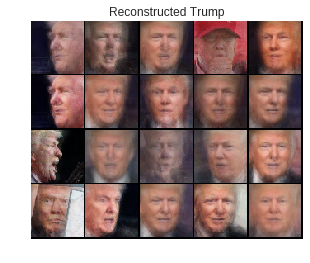

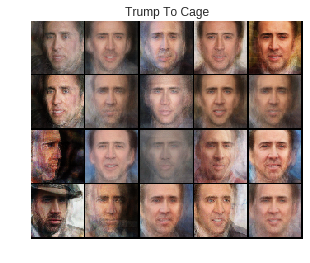

In [8]:
trump_test = get_batch(trump_imgs, 20)
trump_back = ae2.predict(trump_test.reshape(20, -1)).reshape(-1, 64, 64, 3)
trump_cage = ae1.predict(trump_test.reshape(20, -1)).reshape(-1, 64, 64, 3)

show(trump_test, 'Trump')
show(trump_back, 'Reconstructed Trump')
show(trump_cage, 'Trump To Cage')

# Report

## Application

1. Unsupervised Discovery of Object Landmarks as Structural Representations, CVPR 2018. [link](http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Unsupervised_Discovery_of_CVPR_2018_paper.pdf)

2. Word Embedding. [link](https://www.doc.ic.ac.uk/~js4416/163/website/nlp/)

3. Image Denoising.

## Learn

I've tried to train CNN-based encoder/decoders, but found difficult to train and worse result. I guess it is due to lesser parameter. A FC-based autoencoder has 10x to 20x more parameters to train than a CNN-based one. But I'm not sure, since Conv-based network usually has better performance than a FC-based network.

Keras is much more easy to write than tensorflow, and I think than we should not learn the "low-level" api of tensorflow. I heard that tensorflow 2.0 will deprecate those api. We will use keras api or slim api instead.
